El objetivo de este notebook es cargar los archivos csv de la tasa objetivo, INPC y tipo de cambio para limpiarlos, transformar las fechas a data_time y poner las fechas como indices. Ademas, limpiar los datos y ajustar los datos diarios para homologarlos a mensuales. 

In [22]:
import pandas as pd 
import os
import sys
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression


#Nos permite subir de nivel para acceder a otras carpetas
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from banxico_utils import convertirDF
#Guardar la direccion de la carpeta donde estan nuestros archivos     
data_dir = os.path.join(project_root, 'data')
print(f"Buscando datos en: {data_dir}")

#Construimos las rutas finales a los CSV
ruta_tasa = os.path.join(data_dir, "TasaObjetivo.csv")
ruta_INPC = os.path.join(data_dir, "INPCGeneral.csv")
ruta_tipo_cambio = os.path.join(data_dir, "TipoDeCambio.csv")




#Cargar archivos csv
try:
    df_TasaObjetivo=pd.read_csv(ruta_tasa)
    df_INPC=pd.read_csv(ruta_INPC)
    df_TipoCambio=pd.read_csv(ruta_tipo_cambio)
    print("Archivos cargados con exito; DF creados.")
except FileNotFoundError:
    print("Error al cargar archivos")
    
    
#Llamar a funcion para convertir fechas 
df_TasaObjetivoI=convertirDF(df_TasaObjetivo)
df_INPCI=convertirDF(df_INPC)
df_TipoCambioI=convertirDF(df_TipoCambio)

#Imprimir DF solo para comprobar que se hayan aplicado los cambios a los DF
print(df_TasaObjetivoI.head(5))
print(df_INPCI.head(5))
print(df_TipoCambioI.head(5))
    
    

Buscando datos en: d:\PROYECTOS AMBICIOSOS\Banxico-policy-analysis\data
Archivos cargados con exito; DF creados.
            dato
fecha           
2008-01-21   7.5
2008-01-22   7.5
2008-01-23   7.5
2008-01-24   7.5
2008-01-25   7.5
                 dato
fecha                
2008-01-01  65.350564
2008-02-01  65.544834
2008-03-01  66.019891
2008-04-01  66.170127
2008-05-01  66.098635
               dato
fecha              
2008-01-02  10.8972
2008-01-03  10.8842
2008-01-04  10.9277
2008-01-07  10.9208
2008-01-08  10.8850


El siguiente paso es conseguir que todos los datos queden en una serie de tiempo mensual. Como cada dato tiene una naturaleza diferente, se tratarán de distintas formas.
Tambien haremos una concatenacion para guardar los tres df en un unico df


In [23]:
#Usar resample para INPC que ya es mensual, pero queremos que se asigne al ultimo dia de dicho mes
df_INPCm=df_INPCI.resample("ME").mean()
#Usar resample para tipo de cambio
df_TipoCambiom=df_TipoCambioI.resample("ME").mean()
#Usar resample para tasa objetivo
df_TasaObjetivom=df_TasaObjetivoI.resample("ME").asfreq().ffill()

#Cambiar el nombre de la columna dato en cada df para identificarlos posteriormente
df_INPCm=df_INPCm.rename(columns={"dato":"INPC"})
df_TipoCambiom=df_TipoCambiom.rename(columns={"dato":"TdC"})
df_TasaObjetivom=df_TasaObjetivom.rename(columns={"dato":"TO"})


#Crear nuestro dataframe maestro concatenando los tres df
listaDF=[df_INPCm,df_TipoCambiom,df_TasaObjetivom]

df_maestro=pd.concat(listaDF,axis=1,join="outer",ignore_index=False).dropna()
print(df_maestro.head(5))



"""""
#Crear ruta para guardar el dataframe maestro 
ruta_dfMaestro=os.path.join(data_dir, "DataFrameMaestro.csv")

#Guardar en archivo csv
df_maestro.to_csv(ruta_dfMaestro,index=False)
"""


                 INPC        TdC   TO
fecha                                
2008-01-31  65.350564  10.910014  7.5
2008-02-29  65.544834  10.766530  7.5
2008-03-31  66.019891  10.731311  7.5
2008-04-30  66.170127  10.515350  7.5
2008-05-31  66.098635  10.435152  7.5


'""\n#Crear ruta para guardar el dataframe maestro \nruta_dfMaestro=os.path.join(data_dir, "DataFrameMaestro.csv")\n\n#Guardar en archivo csv\ndf_maestro.to_csv(ruta_dfMaestro,index=False)\n'

Normalizar los datos utilizando el objeto de la libreria scikit-learn para que estén en la misma escala. Posterior a eso graficarlos.

                INPC       TdC        TO
fecha                                   
2008-01-31  0.000000  0.056547  0.545455
2008-02-29  0.002561  0.046412  0.545455
2008-03-31  0.008825  0.043924  0.545455
2008-04-30  0.010806  0.028668  0.545455
2008-05-31  0.009863  0.023003  0.545455


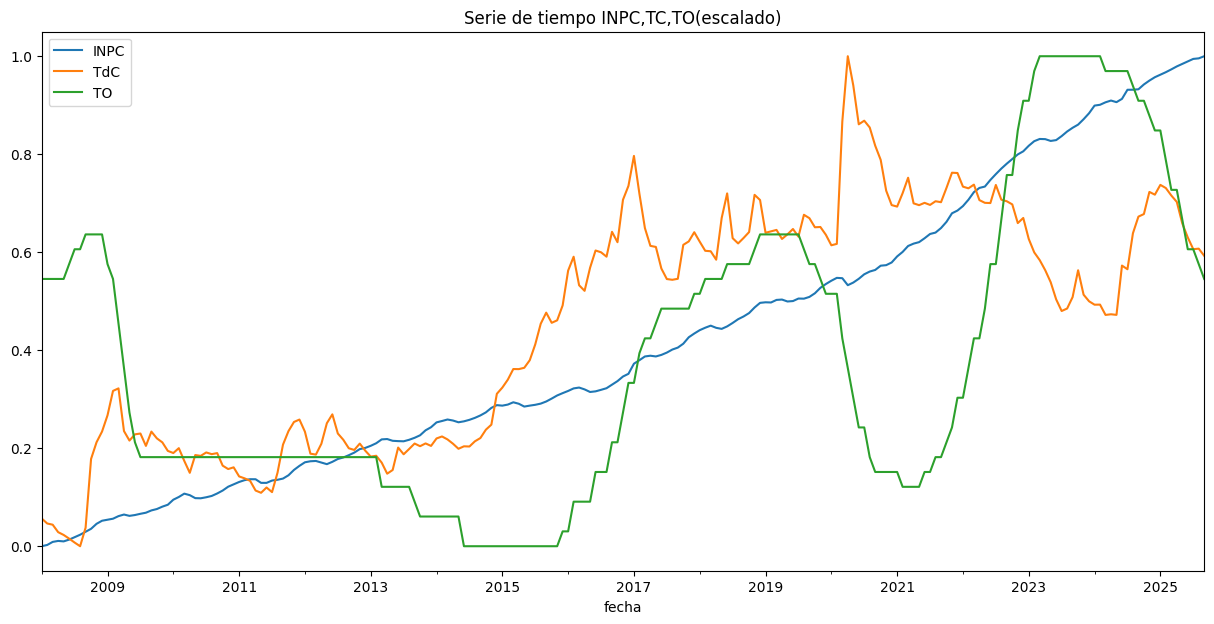

In [24]:
#Crear instancia del objeto 
escalador=MinMaxScaler()

#Usar metodo para calcular los maximo y minimo del conjunto de datos
maestroEscalado=escalador.fit_transform(df_maestro)

#Primero estan los valores del INPC, despues los valores del tipo de cambio y por ultimo la tasa objetivo
#print(maestroEscalado)

#Transformar array de numpy en dataframe de pandas conservando el indice y las columnas del dataframe maestro original 
df_maestroEscalado=pd.DataFrame(maestroEscalado,columns=df_maestro.columns,index=df_maestro.index)

print(df_maestroEscalado.head(5))

#Graficar el df_maestro escalado
df_maestroEscalado.plot(figsize=(15,7),title="Serie de tiempo INPC,TC,TO(escalado)")

plt.show()


El siguiente paso es utilizar el dataframe maestro sin escalar, para medir la correlacion entre las variables. 


          INPC       TdC        TO
INPC  1.000000  0.760665  0.651897
TdC   0.760665  1.000000  0.359848
TO    0.651897  0.359848  1.000000


<Axes: >

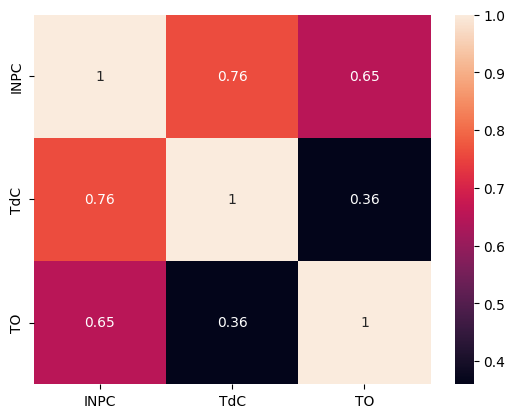

In [25]:
df_correlacion=df_maestro.corr()
print(df_correlacion)

sns.heatmap(df_correlacion,annot=True)



La siguiente seccion trabajará con la ingenieria de caracteristicas, para poder transformar las variables que tengo, a variables con rezagos.
El resultado serán muchos dataframe con distintas temporalidades.

In [26]:
#Dataframe de tasa objetivo
df_maestro["TasaLag_6M"]=df_maestro["TO"].shift(6)
df_maestro["TasaLag_9M"]=df_maestro["TO"].shift(9)
df_maestro["TasaLag_12M"]=df_maestro["TO"].shift(12)
df_maestro["TasaLag_18M"]=df_maestro["TO"].shift(18)

#Dataframe de tipo de cambio
df_maestro["TCLag_1M"]=df_maestro["TdC"].shift(1)
df_maestro["TCLag_3M"]=df_maestro["TdC"].shift(3)

#Dataframe de INPC
df_maestro["INPCLag_1M"]=df_maestro["INPC"].shift(1)

#Crear dataframe maestro con nuevas columnas libre de NaN

df_maestroLimpio=df_maestro.dropna()
df_maestroFinal=df_maestroLimpio.copy()
df_maestroFinal=df_maestroFinal.drop(columns=["TdC","TO","INPCLag_1M"])
print(df_maestroFinal.head(5))


                 INPC  TasaLag_6M  TasaLag_9M  TasaLag_12M  TasaLag_18M  \
fecha                                                                     
2009-07-31  70.370516        7.75        8.25         8.00          7.5   
2009-08-31  70.538884        7.50        8.25         8.00          7.5   
2009-09-30  70.892716        6.75        8.25         8.25          7.5   
2009-10-31  71.107191        6.00        7.75         8.25          7.5   
2009-11-30  71.476046        5.25        7.50         8.25          7.5   

             TCLag_1M   TCLag_3M  
fecha                             
2009-07-31  13.341795  13.436745  
2009-08-31  13.365409  13.162085  
2009-09-30  13.008033  13.341795  
2009-10-31  13.421152  13.365409  
2009-11-30  13.225659  13.008033  


La siguiente sección busca entrenar el modelo de Random Forest Regressor.

In [27]:
#Columnas X
ColumnasX=["TasaLag_6M","TasaLag_9M","TasaLag_12M","TasaLag_18M","TCLag_1M","TCLag_3M" ]

#Creacion de array en numpy y df

X=df_maestroFinal[ColumnasX]
Y=df_maestroFinal["INPC"]

#Division de datos para entrenamiento y para evaluacion
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42,shuffle=False)


#Instanciando objeto RFR
ModeloRFR=RandomForestRegressor(n_estimators=100,random_state=42,max_depth=3,min_samples_leaf=10)

#Entrenar modelo de RFR
ModeloRFR.fit(X_train,Y_train)



#PRUEBA DE OVERFITTING PARA RANDOM FOREST REGRESSION
#Calcular R cuadrada de test
R2Te=ModeloRFR.score(X_test, Y_test)
#Calcular R cuadrada de train
R2Tr=ModeloRFR.score(X_train, Y_train)

print(f"Coeficiente de Determinación test: {R2Te}")
print(f"Coeficiente de Determinación train: {R2Tr}")



#Inicializar y entrenar el modelo de Regresion Lineal

modeloRL=LinearRegression()
modeloRL.fit(X_train,Y_train)


#PRUEBA DE OVERFITTING PARA MODELO DE REGRESION LINEAL
#Calcular R cuadrada de test
R2TeL=modeloRL.score(X_test, Y_test)
#Calcular R cuadrada de train
R2TrL=modeloRL.score(X_train, Y_train)

print(f"Coeficiente de Determinación test RL: {R2TeL}")
print(f"Coeficiente de Determinación train RL: {R2TrL}")






Coeficiente de Determinación test: -56.33648607297312
Coeficiente de Determinación train: 0.9702984855204463
Coeficiente de Determinación test RL: -40.755380148226166
Coeficiente de Determinación train RL: 0.8346347687793714


REPORTE FINAL DE IMPORTANCIA DE VARIABLES
TCLag_3M       0.519668
TasaLag_6M     0.312841
TCLag_1M       0.119250
TasaLag_18M    0.034405
TasaLag_9M     0.013812
TasaLag_12M    0.000024
dtype: float64


<Axes: >

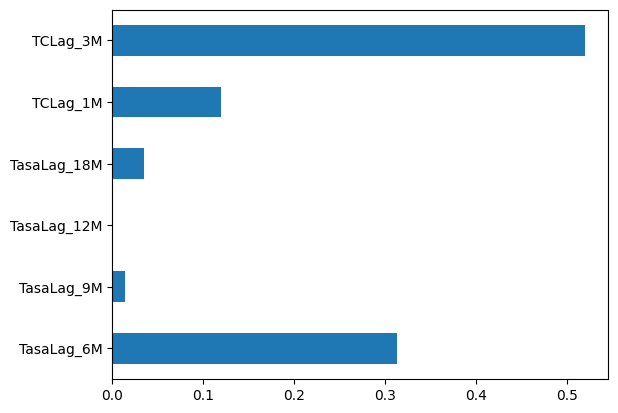

In [ ]:
#Instanciar el modelo con la poda
modeloRFRfinal = RandomForestRegressor(n_estimators=100,random_state=42,max_depth=3,min_samples_leaf=10)

#Entrenar el modelo con todos los datos 
modeloRFRfinal.fit(X, Y)
#Aplicar la funcion de importancia de caracteristicas
ImportanciaCaracteristicas=modeloRFRfinal.feature_importances_


#Serie de Pandas para etiquetar los números
reporte_importancia = pd.Series(ImportanciaCaracteristicas, index=ColumnasX)


print("REPORTE FINAL DE IMPORTANCIA DE VARIABLES")
print(reporte_importancia.sort_values(ascending=False))
#Graficar
reporte_importancia.plot(kind="barh")
